In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
from fancy_round import fancy_round
from wb_api_wrapper import *
import numpy as np
import pandas as pd


C:\Users\Admin\Anaconda3\lib\site-packages\pandas\io\wb.py:19: FutureWarning: 
The pandas.io.wb module is moved to a separate package (pandas-datareader) and will be removed from pandas in a future version.
After installing the pandas-datareader package (https://github.com/pydata/pandas-datareader), you can change the import ``from pandas.io import data, wb`` to ``from pandas_datareader import data, wb``.
  FutureWarning)


### Data from WDI

In [5]:
wb_countries = pd.read_csv("wb_countries.txt",sep="\t",header=None, squeeze=True)

In [6]:
data_ = get_wb("NY.GDP.PCAP.KN")#GDP per capita (constant LCU)
""" NY.GDP.MKTP.KD.ZG real growth ong serie
"NY.GDP.PCAP.PP.CD"  ppp gdp pc short series
NY.GDP.MKTP.KD 
NY.GDP.PCAP.KD""";

data = data_.ix[data_.index.isin(wb_countries)] #Takes only actual countries (filters things like LAC out)

In [7]:
data.index.values;

### Data from PWT (not appropriate)

In [8]:
iso_to_wb =pd.read_csv('iso3_to_wb_name.csv',index_col="iso3",squeeze=True);

def replace_with_warning(series_in,dico):
    out=series_in.replace(dico)
    bads = [c for c in out if c not in dico.tolist()]
    if bads !=[]:
        warnings.warn("\nbad country names : "+",".join(bads))

    return out

if False:
    #Data on real GDP per capita. Ends in 2002, so not used
    pwt = pd.read_csv("FebPwtExport11172015.csv").drop("VariableCode",axis=1).rename(columns={"YearCode":"year"})
    pwt["country"] = replace_with_warning(pwt["RegionCode"],iso_to_wb)

    #pivots data
    hop=pwt.set_index(["country"])[["year","AggValue"]]
    data_pwt=hop.pivot(columns="year",values="AggValue")



#Data on pop and reald gdp PPP. Ends in 2010, so better.
pwt= pd.read_csv("pwt_rgdpe_pop_8.1.csv").rename(columns={"YearCode":"year"})
pwt["country"] = replace_with_warning(pwt["RegionCode"],iso_to_wb)

gdp=pwt.set_index(["country"]).query("VariableCode=='rgdpe'")[["year","AggValue"]].pivot(columns="year",values="AggValue")
pop=pwt.set_index(["country"]).query("VariableCode=='pop'")[["year","AggValue"]].pivot(columns="year",values="AggValue")
data_pwt=gdp/pop
data_pwt.head()

year,1950,1960,1970,1980,1990,2000,2010
country,,,,,,,
Albania,NaN,NaN,3766.493488,4452.976576,4530.989903,4466.585358,7357.165365
Angola,NaN,NaN,3210.416964,2519.768588,2642.631539,2318.199248,5128.301854
Antigua and Barbuda,NaN,NaN,4323.554046,5735.031122,12019.787888,13379.636257,13331.033111
Argentina,2149.967856,2391.240933,2962.784587,3385.293545,4619.843833,10602.432348,14211.016385
Armenia,NaN,NaN,NaN,NaN,3895.470798,2580.807534,5045.369734


# Process the data

Series([], Name: year, dtype: float64)


count    203.000000
mean       2.778062
std        3.258115
min       -9.388767
25%        1.101712
50%        2.587352
75%        4.155794
max       16.171492
Name: 0, dtype: float64

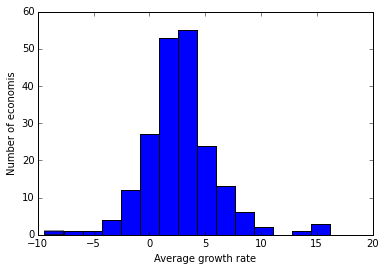

In [9]:
gdp_now  = mrv(data)
gdp_then = lrv(data)

now = mr_year(data).astype('float64')
then = lr_year(data).astype('float64').clip(lower=now-30)

pd.DataFrame([then,gdp_then, now, gdp_now],index=["year","GDPpc","year","GDPpc"]).T.to_excel("growth.xlsx")
growth_rates=(np.power(gdp_then/gdp_now, -1/(now-then))-1)*100


#removes countries with little data
print((now-then)[(now-then<4)])
growth_rates[(now-then<4)]=np.nan


#Stats
ax=(1.5*growth_rates).hist(bins=15,grid="off")
ax.set_xlabel("Average growth rate")
ax.set_ylabel("Number of economis")
(1.5*growth_rates).describe()

In [10]:
x=pd.DataFrame([then,gdp_then, now,gdp_now],index=["then","gdp_then","now","gdp_now"])
x["Congo, Dem. Rep."]

then          1984.000000
gdp_then    290810.786922
now           2014.000000
gdp_now     134337.048117
Name: Congo, Dem. Rep., dtype: float64

In [17]:
#Output

g=growth_rates.apply(fancy_round).dropna()
g.to_csv("growth_rates.csv")

g=g.reset_index()


#g.to_csv("list_growth_rates_range.csv",index=None)

#with open("Output.txt", "w") as text_file:
#    text_file.write(", ".join(g))


def arrange_in_n_columns(g,n=3):
    #Arrange over n columns
    for i in np.arange(0,n-np.mod(g.shape[0],n)):
        g.loc[len(g)+1]=" "
    return pd.DataFrame(g.reshape(3,g.shape[0]/n)).T

arrange_in_n_columns(g["country"]+" "+g[0].astype(str)+u"\u2014"+(2*g[0]).astype(str)).to_csv("growth_rates_range_three_columns.csv",header=None,index=None)    

arrange_in_n_columns(g["country"]+" "+(1.5*g[0]).apply(fancy_round).astype(str)).to_csv("growth_rates_15_three_columns.csv",header=None,index=None)  